# Customer Market Segmentation with Unsupervised Learning

#### DTSA 5510: Unsupervised Algorithms in Machine Learning

In this notebook, I'll import, explore, and clean a dataset, use it to group customers together, find which marketing campaigns are most closely associated with the groups, and reflect on key findings.

The full GitHub repo for this project can be found at https://github.com/23ccozad/customer-segmentation.

First, I'll begin by importing the libraries needed to run this notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA, NMF
from sklearn.neighbors import NearestNeighbors

In [65]:
pd.set_option('display.max_columns', 30)  # Show up to 30 columns

###  Gather data, determine the method of data collection and provenance of the data (3 points)

*Instructions: In the earliest phase, select a data source and problem.*

I retrieved this [Customer Segmentation dataset](https://www.kaggle.com/datasets/vishakhdapat/customer-segmentation-clustering/) from Kaggle. It has many columns that describe customers, as well as whether the customer has engaged with any of five marketing campaigns:

In [3]:
data = pd.read_csv('/content/drive/MyDrive/CU Boulder Data Science/DTSA 5510 - Unsupervised Algorithms in Machine Learning/Final Project/customer_segmentation.csv')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


As you can see from the **brief preview** above, we have information such a year of birth, education, marital status, and income that can tell us what kinds of marketing might appeal to the customer. We also have multiple columns titled "AcceptedCmp" followed by a number between 1 and 5, which tells us whether the customer engaged with the marketing campaign numbered 1 through 5.

The exact **source and provenance** for this dataset is unclear, as Kaggle provided no further information about how the data was collected or who collected. I would assume this dataset was collected by a marketing firm that surveyed potential customers and tracked whether they interacted with one of their marketing campaigns.

The **problem** I'll attempt to solve is determining which marketing campaigns were most successful with which types of customers. The marketing firm could use this information to better direct advertisements to their target audiences in future campaigns.

### Identify an Unsupervised Learning Problem (6 points)

*Model building and training may depend on their data type(s) and task type(s). When using multiple models, at least one of them should be an unsupervised approach. Projects should focus on model building and/or analysis.*

**Problem**: Determine which marketing campaigns were most successful with which customers.

One of the core responsibilities of a marketing firm is to direct advertisements to the right customers. Efficiency in this regard allows companies to spend less money on advertising, while hopefully increasing sales. The customer acquistion cost is a key metric in marketing that comapnies want to decrease as much as possible, while consistently increasing sales. Knowing your customers and where to reach them is an important component to any marketing strategy.

**Proposed solution**: The dataset I've imported has information about customers and which marketing campaigns they interacted with. I will group customers together that have similar qualities, using various unsupervised clustering techniques, and then see which clusters interacted with which marketing campaigns most frequently. The outcomes of this project should not only be enlightening, but also allow future marketing campaigns to figure out which group a customer falls into, and whether the customer is part of the campaign's target audience.

**Model building and training** will be a key part of this project. I will explore different types of clustering algorithms to create the groups of customers. I'll also look into matrix factorization to create groups as well. Hyperparameter tuning will focus on choosing the best number of clusters using the Calinski-Harabasz Index. After finding the best clustering method, from that method will be examined and explained in the context of the business problem at hand.

### Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)

*Instructions: Go through the initial data cleaning and EDA and judge whether you need to collect more or different data.*

#### Dataset shape and size

In [4]:
data.shape

(2240, 29)

The dataset has **2,240 customers and 29 features**.

We can also take a look at a summary statistics for the numeric columns:

In [5]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


#### Transform data types

There are 29 columns, let's see what each is about and whether they're in the right format.

In [6]:
data.dtypes

,0
ID,int64
Year_Birth,int64
Education,object
Marital_Status,object
Income,float64
Kidhome,int64
Teenhome,int64
Dt_Customer,object
Recency,int64
MntWines,int64


We also have this information from Kaggle about each column:

* Id: Unique identifier for each individual in the dataset.
* Year_Birth: The birth year of the individual.
* Education: The highest level of education attained by the individual.
* Marital_Status: The marital status of the individual.
* Income: The annual income of the individual.
* Kidhome: The number of young children in the household.
* Teenhome: The number of teenagers in the household.
* Dt_Customer: The date when the customer was first enrolled or became a part of the company's database.
* Recency: The number of days since the last purchase or interaction.
* MntWines: The amount spent on wines.
* MntFruits: The amount spent on fruits.
* MntMeatProducts: The amount spent on meat products.
* MntFishProducts: The amount spent on fish products.
* MntSweetProducts: The amount spent on sweet products.
* MntGoldProds: The amount spent on gold products.
* NumDealsPurchases: The number of purchases made with a discount or as part of a deal.
* NumWebPurchases: The number of purchases made through the company's website.
* NumCatalogPurchases: The number of purchases made through catalogs.
* NumStorePurchases: The number of purchases made in physical stores.
* NumWebVisitsMonth: The number of visits to the company's website in a month.
* AcceptedCmp3: Binary indicator (1 or 0) whether the individual accepted the third marketing campaign.
* AcceptedCmp4: Binary indicator (1 or 0) whether the individual accepted the fourth marketing campaign.
* AcceptedCmp5: Binary indicator (1 or 0) whether the individual accepted the fifth marketing campaign.
* AcceptedCmp1: Binary indicator (1 or 0) whether the individual accepted the first marketing campaign.
* AcceptedCmp2: Binary indicator (1 or 0) whether the individual accepted the second marketing campaign.
* Complain: Binary indicator (1 or 0) whether the individual has made a complaint.
* Z_CostContact: A constant cost associated with contacting a customer.
* Z_Revenue: A constant revenue associated with a successful campaign response.
* Response: Binary indicator (1 or 0) whether the individual responded to the marketing campaign.

It looks like **the data types for all of these columns is appropriate**, and many are already in numeric format, which is great.

#### Drop unnecessary columns

We can drop the ID column, since it's just an arbitrary identifier, and shouldn't help us cluster similar customers together.

In [7]:
data.drop('ID', axis=1, inplace=True)

#### Handle missing values

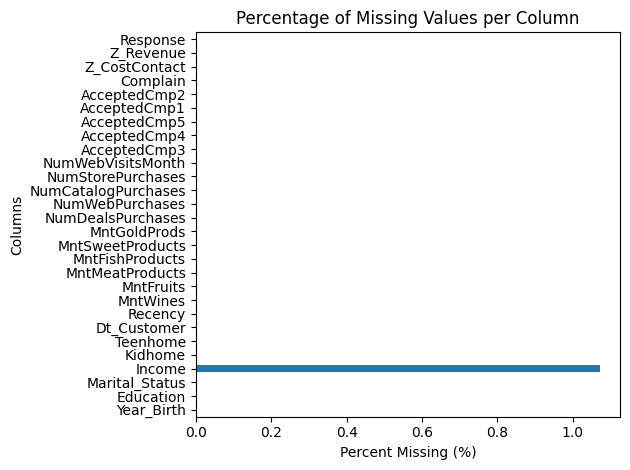

In [8]:
missing_percent = data.isnull().mean() * 100

missing_percent.plot(kind='barh')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Columns')
plt.xlabel('Percent Missing (%)')
plt.tight_layout()
plt.show()

We have bery few missing values in this dataset, which is great. Note that there's about 1% of values missing in the income column. We might be able to **impute missing income values with a regression**, which would likely be more accurate than imputing the mean or median income value.

To begin that process, let's see which variables are most closely correlated with income.

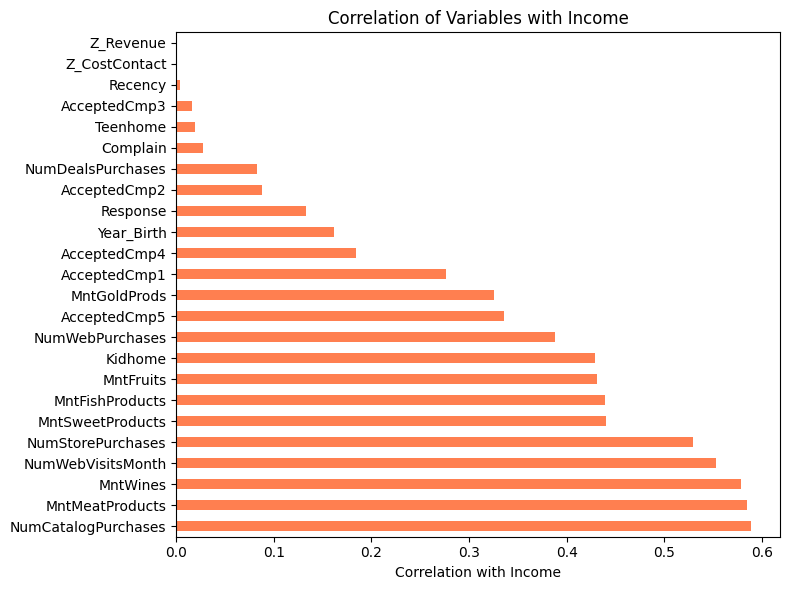

In [9]:
correlation_matrix = data.corr(numeric_only=True)
income_corr = correlation_matrix['Income'].abs().sort_values(ascending=False)
income_corr_no_self = income_corr.drop('Income')

plt.figure(figsize=(8, 6))
income_corr_no_self.plot(kind='barh', color='coral')
plt.xlabel('Correlation with Income')
plt.title('Correlation of Variables with Income')
plt.tight_layout()
plt.show()

It looks like we have **5 variables with the highest correlation** with income, so let's use **those 5 variables to create a regression that can fill in our missing income values.**

Now, we'll train the regression model:

In [10]:
data_income_missing = data[data['Income'].isnull()]
data_income_known = data[data['Income'].notnull()]

predictors = ['NumCatalogPurchases', 'MntMeatProducts', 'MntWines', 'NumWebVisitsMonth', 'NumStorePurchases']

X_train = data_income_known[predictors]
y_train = data_income_known['Income']

model = LinearRegression()
model.fit(X_train, y_train)

X_missing = data_income_missing[predictors]

predicted_income = model.predict(X_missing)
predicted_income

array([32997.04037375, 48969.19357352, 54438.48912501, 40111.51472056,
       37182.83052247, 31906.1501291 , 41562.78819195, 33070.05464264,
       74059.31983186, 48299.82101541, 58313.55851331, 82378.07405987,
       59769.30863965, 48701.83529589, 40125.65243969, 33047.34215917,
       34355.70782907, 63666.9281389 , 37302.33816154, 33277.32913543,
       41906.1715222 , 41816.53475824, 81428.55849134, 80195.93279545])

Is the model any good? Let's look at the R squared value:

In [11]:
model.score(X_train, y_train)

0.5183444390942574

The R sqaured value is 0.52, which is mediocre, but this is probably still better than imputing all missing values with the column's median.

The predicted income values look to be in the reasonable range of incomes for this dataset. Let's make a quick comaprison by plotting the predicted values against just one of the predictors from the regression. This won't give us a complete view of the regression, but is a good sanity check that the predictions make sense.

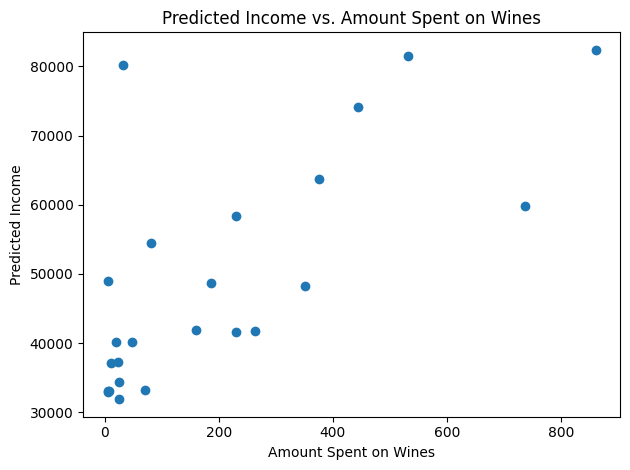

In [12]:
plt.scatter(X_missing['MntWines'], predicted_income)
plt.title('Predicted Income vs. Amount Spent on Wines')
plt.ylabel('Predicted Income')
plt.xlabel('Amount Spent on Wines')
plt.tight_layout()
plt.show()

It seems reasonable that the more income youy have, the more you might spend on discretionary expenses, such as wine.

Let's go ahead and implement the predicted values to fill in the missing values for income.

In [13]:
data.loc[data['Income'].isnull(), 'Income'] = predicted_income

#### Encode categorical columns

There's also a few categorical columns in this dataset, which we'll need to turn into numeric columns in order to perform clustering later on. Let's find out which columns those are and address them:

In [14]:
data.dtypes[~data.dtypes.apply(pd.api.types.is_numeric_dtype)]

,0
Education,object
Marital_Status,object
Dt_Customer,object


There are three columns I'll transform: education, marital status, and dt_customer. Let's see if these are nomial or ordinal columns, since that will affect how they should be encoded.

In [15]:
data['Education'].value_counts()

,count
Education,
Graduation,1127
PhD,486
Master,370
2n Cycle,203
Basic,54


In [16]:
data['Marital_Status'].value_counts()

,count
Marital_Status,
Married,864
Together,580
Single,480
Divorced,232
Widow,77
Alone,3
Absurd,2
YOLO,2


In [17]:
data['Dt_Customer'].value_counts()

,count
Dt_Customer,
31-08-2012,12
12-05-2014,11
14-02-2013,11
12-09-2012,11
22-05-2014,10
...,...
01-11-2013,1
10-08-2013,1
11-10-2012,1


Ok, let's start transforming these columns.

First, is education level. The education levels are European, and it appears the order of these education levels is: basic, 2n cycle, graduation, master, and PhD. I'll use **ordinal encoding for education levels**, starting at zero and incrementing by one at each level.

In [18]:
education_ordinal = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

data['Education_encoded'] = data['Education'].map(education_ordinal)
data[['Education_encoded', 'Education']]

,Education_encoded,Education
0,2,Graduation
1,2,Graduation
2,2,Graduation
3,2,Graduation
4,4,PhD
...,...,...
2235,2,Graduation
2236,4,PhD
2237,2,Graduation
2238,3,Master


Then there's marital status, which doesn't have an entirely clear order, but the argument could be made that there's generally a progression over time from "single" to "together" to "married" to "divorced" or "widowed". Additionally, we have some non-sense values for martial status, like "Alone", "YOLO", and "Absurd", which should probably be corrected to "single". We can take care of all this with an **ordinal encoding for martial status**.

In [19]:
marital_status_ordinal = {
    'Single': 0,
    'Alone': 0,     # group with single
    'YOLO': 0,      # group with Single
    'Absurd': 0,    # group with Single
    'Together': 1,
    'Married': 2,
    'Divorced': 3,
    'Widow': 4
}

data['Marital_Status_encoded'] = data['Marital_Status'].map(marital_status_ordinal)
data[['Marital_Status_encoded', 'Marital_Status']]

,Marital_Status_encoded,Marital_Status
0,0,Single
1,0,Single
2,1,Together
3,1,Together
4,2,Married
...,...,...
2235,2,Married
2236,1,Together
2237,3,Divorced
2238,1,Together


Lastly, the Dt_Customer column is a date column, which needs to be turned into a numeric column. I'll take the **year from each date and make that the numeric value**, turning the column into an integer.

In [20]:
data['Dt_Customer_encoded'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y').dt.year
data[['Dt_Customer_encoded', 'Dt_Customer']]

,Dt_Customer_encoded,Dt_Customer
0,2012,04-09-2012
1,2014,08-03-2014
2,2013,21-08-2013
3,2014,10-02-2014
4,2014,19-01-2014
...,...,...
2235,2013,13-06-2013
2236,2014,10-06-2014
2237,2014,25-01-2014
2238,2014,24-01-2014


#### Check for and remove outliers

We also need to take a look at the distributions of each variable in order to get a sense of it's range of values, but also to check for any outliers. We can **spot any serious outliers using histograms**. If the scale of the histogram is non-sense, it's usually because there's a value that's way too big or too small.

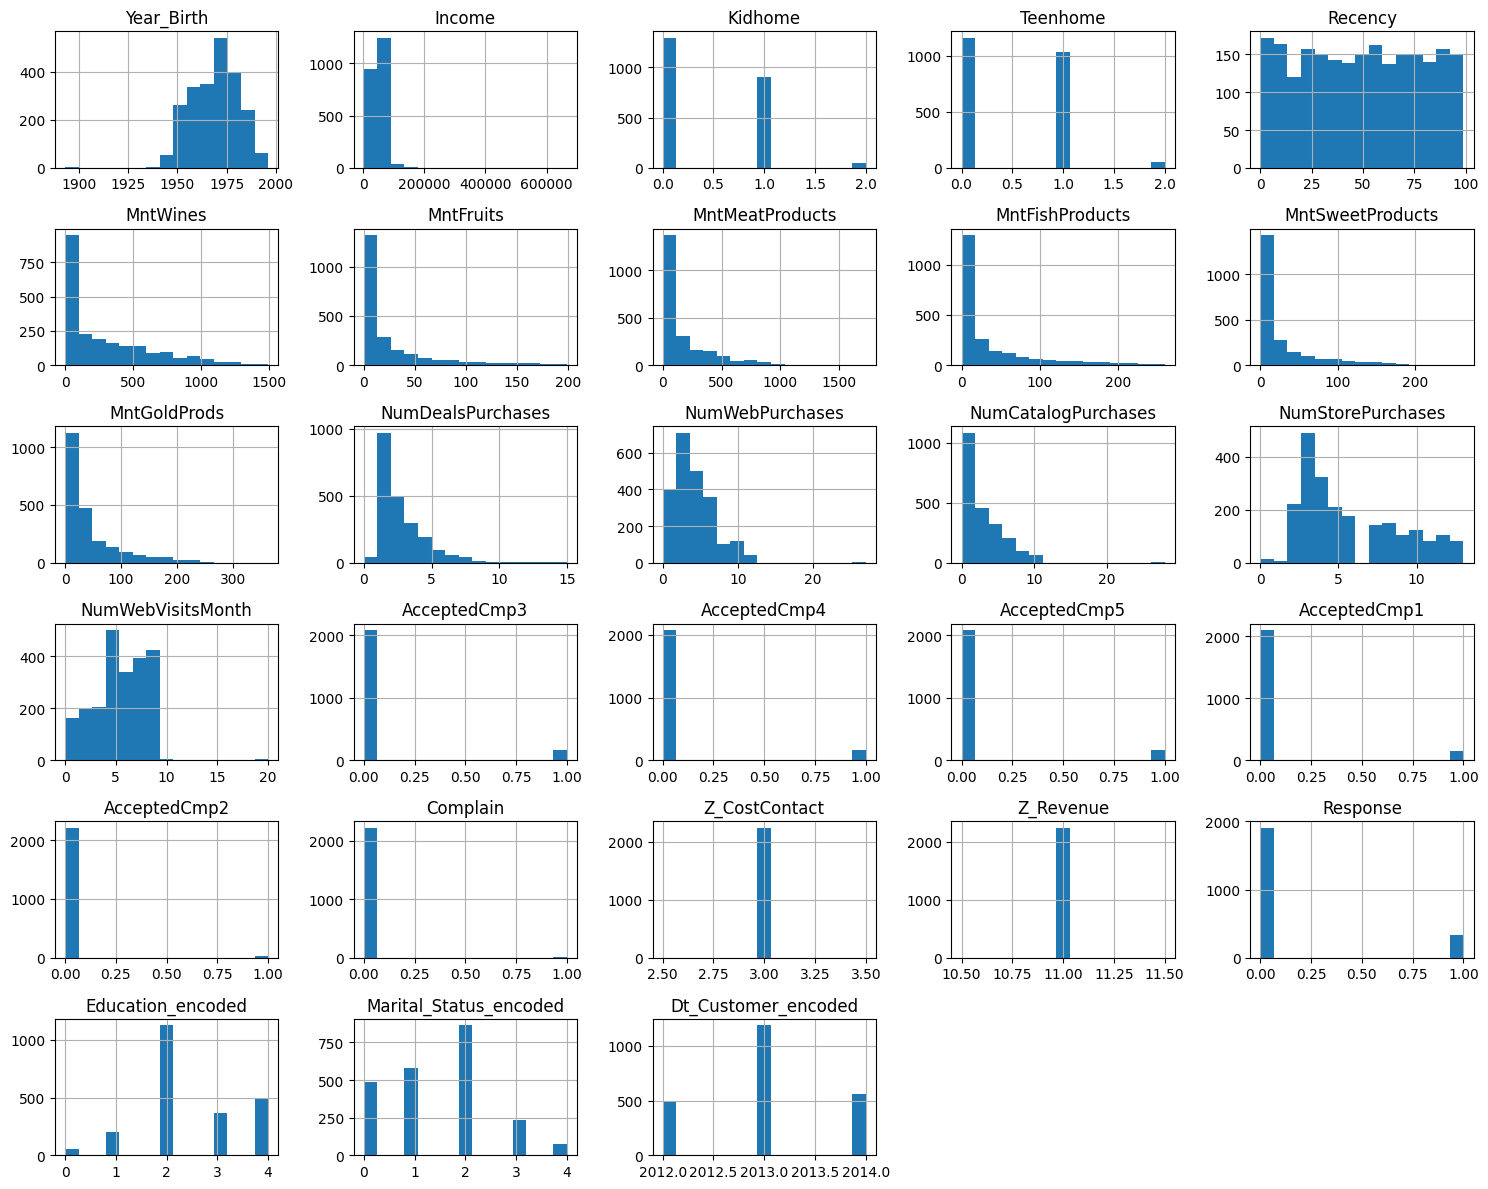

In [21]:
data.hist(bins=15, figsize=(15, 12))
plt.tight_layout()
plt.show()

Based on these histograms, I don't see any major outliers. However, I do notice that the variables Z_CostContact and Z_Revenue only have one value for every row, so we can drop those columns. They provide no predictive information.

In [22]:
data.drop(['Z_CostContact', 'Z_Revenue', 'Response'], axis=1, inplace=True)

#### Explore correlation matrix

Let's take a look at how the different variables are correlated to each other. Since we'll be clustering this data, the correlations between variables could be indications that variables with similar values may lead to customers being grouped together.

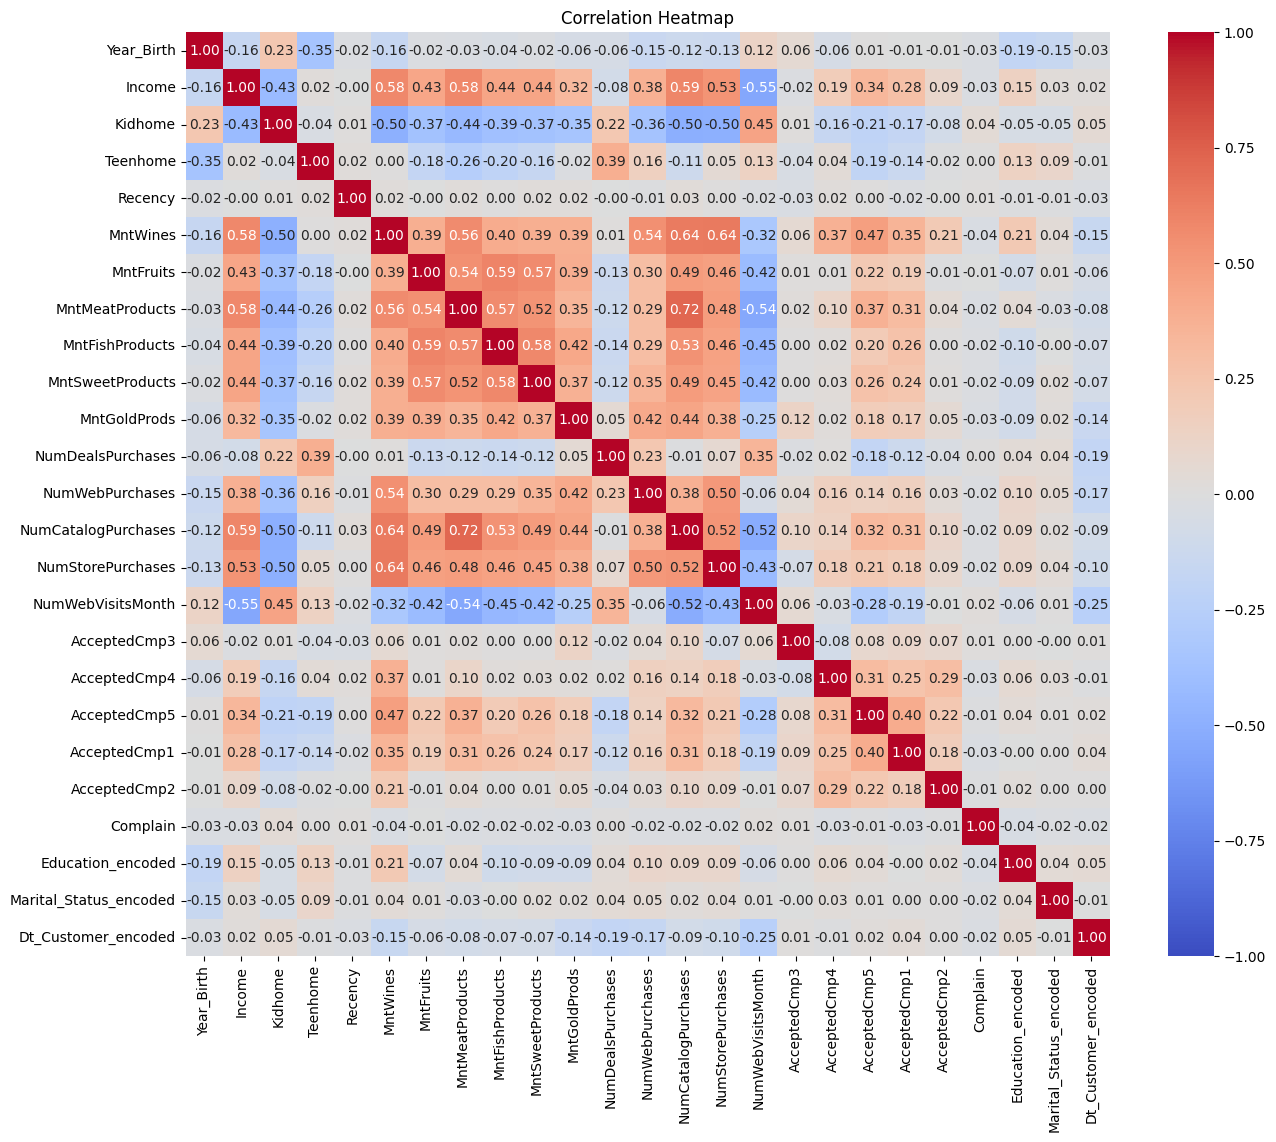

In [23]:
corr = data.select_dtypes(include='number').corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)

plt.title('Correlation Heatmap')
plt.show()

The correlation matrix shows the strength of the linear relationship between each of the pairs of variables in the dataset. Of particular interest to the problem at hand is which variables might be most related to the customers who engaged with each of the marketing campaigns. Here's the **strongest correlation with each "AcceptedCmp" variable**:

*   AcceptedCmp1 is most strongly correlated with AcceptedCmp5 (0.40) and MntWines(0.35)
*   AcceptedCmp2 is most strongly correlated with AcceptedCmp4 (0.29), AcceptedCmp5 (0.22), and MntWines (0.21)
*   AcceptedCmp3 is most strongly correlated with MntGoldProds (0.12)
*   AcceptedCmp4 is most strongly correlated with MntWines (0.37)
*   AcceptedCmp5 is most strongly correlated with MntWines (0.45)

Interesting to see how **people's engagement in these marketing campaigns appears to be related to how much they spend on wine**. Maybe these are wine marketing campaigns? Hard to tell for sure, but maybe we'll learn more by creating the clusters in the next steps.

### Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions (70 points)

*Instructions: Model building and training may depend on their data type(s) and task type(s). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. When using multiple models, at least one of them should be an unsupervised approach. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.*

First, we'll **select the features to use in clusters**. That means excluding the categorical columns (which we already encoded into separate numeric columns). Also, we'll exclude "AcceptedCmp" columns, since we'll use those later to evaluate how they are related to the different clusters.

In [24]:
X = data.select_dtypes(include=np.number).drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], axis=1)

We're left with these columns for clustering:

In [25]:
X.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Complain', 'Education_encoded', 'Marital_Status_encoded',
       'Dt_Customer_encoded'],
      dtype='object')

Additionally, clustering tends to work best when the data is scaled. Here, I used **StandardScaler**, which basically takes each column subtracts its mean from each value, and then divides each of those values by the column's standard deviation (e.g. z-scores for every column).

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Fit a k-means clustering model

Ok, let's dive into some unsupervised learning!

I'll start with the most basic clustering algorithm: k-means clustering. A key aspect for k-means clustering is **choosing k**, which is the hyperparameter that tells the model how many clusters to create. This is a form of **hyperparameter tuning**.

One way to choose k is to use an "elbow plot" to determine where the improvement by adding more clusters diminishes, usually where there is an "elbow" shape to the graph. Here's the elbow plot for k-means for this dataset:

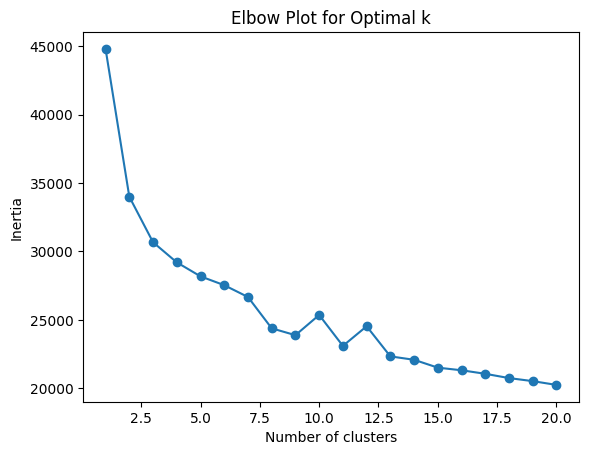

In [27]:
inertia = []
for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 21), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Optimal k')
plt.show()

Well, it's fairly subjective, but you could argue the elbow in this plot is around 3 to 4 clusters. After that, the line decreases at about a linear rate. What if there were a less subjective method to pick the number of clusters? There are! One is called the Calinski-Harabasz Index.

The **Calinski-Harabasz Index** measures the ratio of between-cluster dispersion to within-cluster dispersion. A higher score means the clusters are more well-defined. We can compute this index for different k-values to help choose the best one.

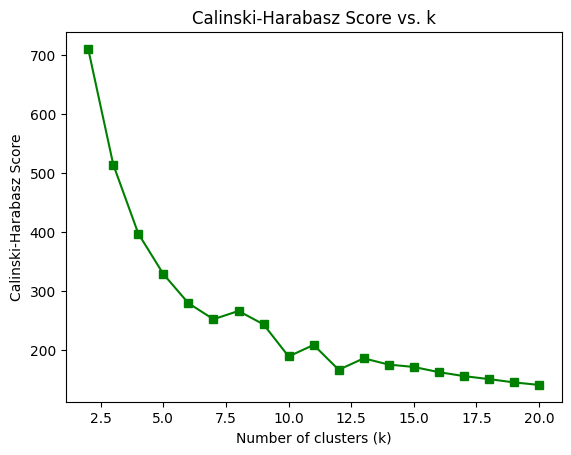

In [28]:
K = range(2, 21)
ch_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=10)
    labels = km.fit_predict(X_scaled)
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

plt.plot(K, ch_scores, marker='s', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. k')
plt.show()

Well, the Calinski-Harabasz index is highest for k=1 and decreases from there. The elbow plot might be the most useful in this case, suggesting that 4 clusters is best. We can always come back and adjust if needed.

Now that we tuned the most important hyperparameter, let's fit the data into cluster using k-means:

In [29]:
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans_clusters = kmeans.fit_predict(X_scaled)
kmeans_clusters

array([1, 3, 1, ..., 1, 2, 3], dtype=int32)

Ok, we made clusters! The output from the k-means algorithm assigned each row in the dataset to a cluster 0, 1, 2, or 3. It's difficult to visually inspect our clusters, since there's many dimensions invovled, but we can use **Principal Component Analysis (PCA)** to summarize our features into 2 principal components, and see if the data looks clustered:

In [30]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

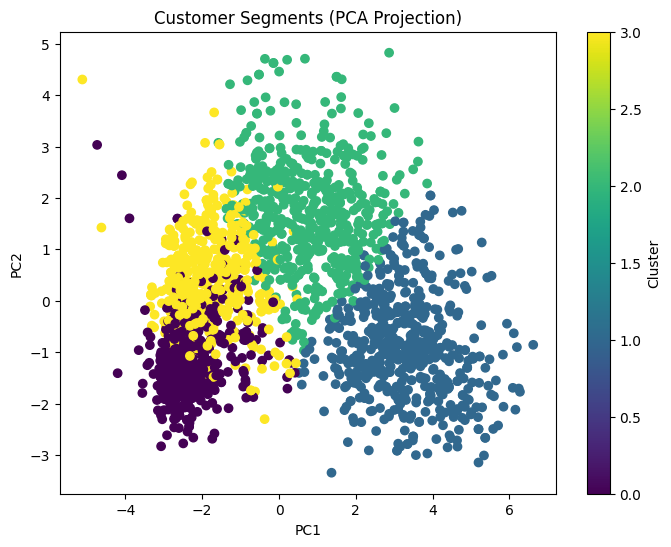

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=kmeans_clusters)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segments (PCA Projection)')
plt.colorbar(label='Cluster')
plt.show()

As you can see, the principal component plot gives us an idea of the clustering that the model performed, visualized in just 2 dimensions.

Now, we'll move on to some other clustering methods, and at the end, use the Calinski-Harabasz Index to compare and choose the best one.

#### Fit an agglomerative clustering model

Another clustering technique is called agglomerative clustering (or heirarchical clustering). It uses a dendrogram to separate data into homogeneous groups.

We'll use the **dendrogram as a hyperparameter tuning technique** to specify the **number of clusters** we want:

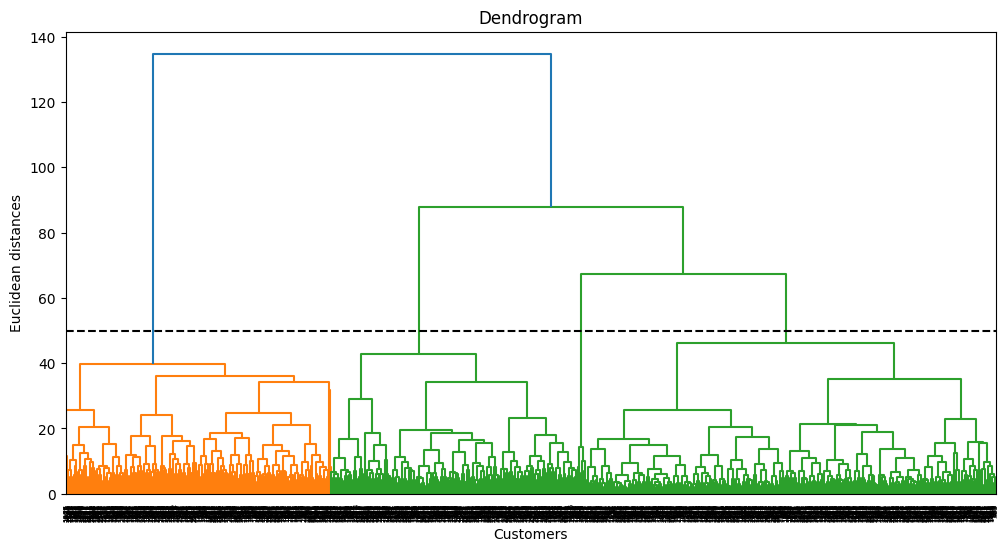

In [32]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.axline((0, 50), (3000, 50), color='black', linestyle='--')
plt.show()

The rule of thumb is to cut the dendrogram at the longest vertical gap between horizontal lines that doesn't intersect any merges. In this case, that would leave us with 2 clusters. I think more than 2 clusters would be helpful, so I elected to cut the dendrogram at the second largest vertical gap that doesn't intersect any merges. That will leave us with 4 clusters instead (denoted by the dashed black line on the diagram).

Let's run agglomerative clustering with 4 clusters.

In [33]:
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(X_scaled)
hc_clusters

array([1, 0, 1, ..., 2, 1, 0])

Once again, we have some clusters, but it would be nice to see a preview of them. I'll use PCA again to show the clusters in two dimensions.

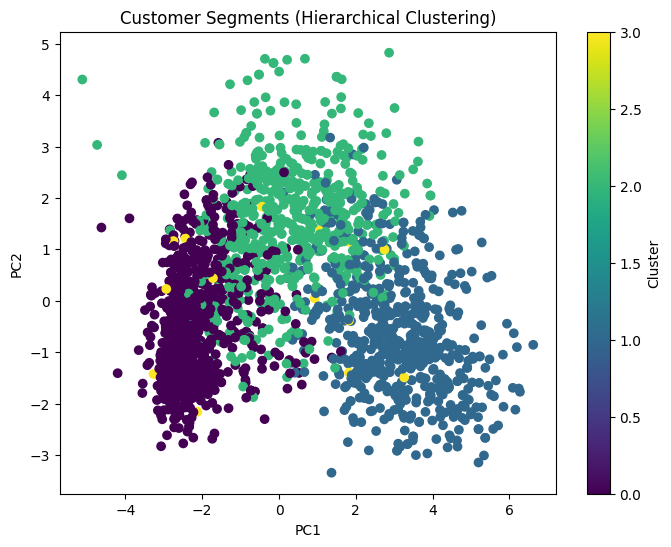

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=hc_clusters)
plt.title('Customer Segments (Hierarchical Clustering)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

The clsuter visualization definitely shows groups of points with the same color near each other. However, cluster 3 (in yellow) is is lacking in appearance. First, there seems to be very few points in cluster 3, and by looking at the dendrogram, you can see which branch of the diagram is much smaller than the rest. Also, the few yellow points in the plot aren't really together, but more spread across the other clusters. Some of that may be a side effect of losing information during PCA, but it seems like 3 clusters may have been a better choice here for agglomerative clustering on this dataset.

#### Fit a DBSCAN clustering model

Now we'll try DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to cluster the data. This method is special because it determines the best number of clusters on it's own, so we don't have to provide it as a hyperparameter. It will also put points into clusters based on density, and points that don't fit into a cluster will be named outliers.

DBSCAN has two hyperparameters we should set:

*   eps: the radius of a neighborhood around each point
*   min_samples: the minimum number of samples needed to create a cluster

I will set min_samples to 10, which is about 5% of the dataset. For eps, we can use a k-distance plot to find the optimal value:


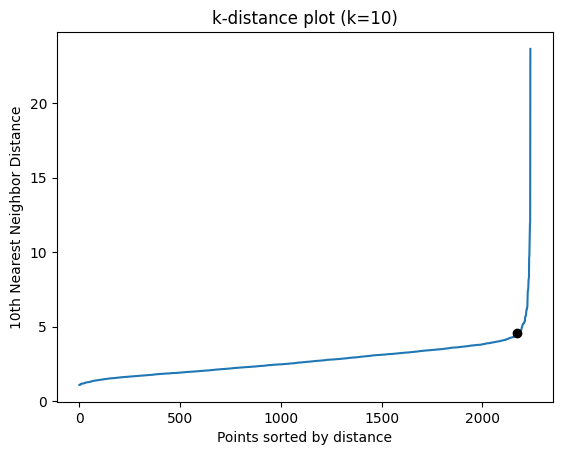

In [35]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 9])
plt.plot(distances)
plt.title("k-distance plot (k=10)")
plt.xlabel("Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.plot(2175, 4.6, marker='o', color='black')
plt.show()

This plot shows the distance from a point to the 5th nearest neighbor, and the "elbow" in this plot is usually a good value for the neighborhood for DBSCAN, which is the eps hyperparameter. That value is highlighted by the point on the plot, which is around 4.2.

In [36]:
db = DBSCAN(eps=4.6, min_samples=10)
db_clusters = db.fit_predict(X_scaled)
db_clusters

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
np.unique(db_clusters, return_counts=True)

(array([-1,  0,  1]), array([  33, 2195,   12]))

It looks like **DBSCAN struggled with this dataset**. I had high hopes since it was going to do the clustering for us without specifying a k-value. However, DBSCAN relies on density, and there may be too many dimensions in this dataset, which reduced the density to a point where DBSCAN doesn't work well.

DBSCAN ended up finding one big cluster, one small cluster, and a small set of outliers. Here is a visualization using PCA:

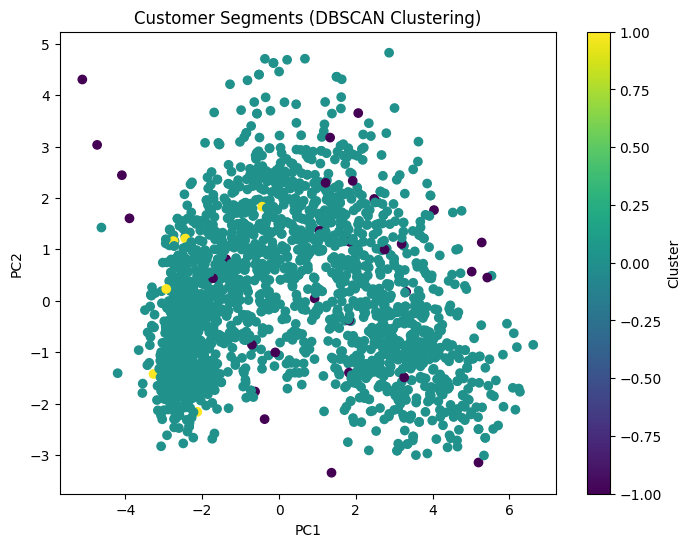

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=db_clusters)
plt.title('Customer Segments (DBSCAN Clustering)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

#### Fit a matrix factorization model

We learned in this course that matrix factorization can also cluster points. In this example, I'll use non-negative matrix factorization (NMF) since all of the data is positive and not missing any values.

For this, I'll use the **MinMaxScaler** to normalize the data without introducing negative values.

In [39]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Now we can factorize the matrix. I tried several different values from n_components and evaluated them visually in the plot below. I decided n_components=3 was the best value.

In [40]:
nmf = NMF(n_components=3, random_state=10)
W = nmf.fit_transform(X_scaled)
nmf_clusters = np.argmax(W, axis=1)

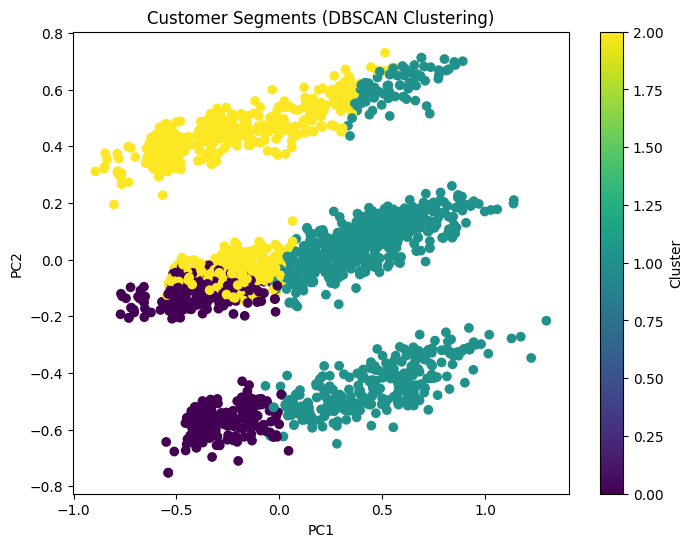

In [41]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=nmf_clusters)
plt.title('Customer Segments (DBSCAN Clustering)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

You might notice that the arrangement of points in the PCA plot above is different than it was for all of the other clustering algorithms. That is a result of having to use MinMaxScaler instead of StandardScaler, since StandardScaler introduces negative values into the dataset, which non-negative matrix factorization (NMF) cannot handle.

Despite the different appearance, we can see that the 3 clusters are there and well-defined.

#### Evaluation of cluster performance

We have made all sorts of different clusters with these 4 techniques:

*   K-means clustering
*   Agglomerative clustering
*   DBSCAN clustering
*   Non-negative matrix factorization

How do we pick which one is best, and move forward with the best set of clusters?

Based on visual inspection of plots using PCA, it appeared that K-means clustering and non-negative matrix factorization proudced the best results. However, we can also take a more quantitative approach to this evaluation.

We'll compute the three most common metrics for evaluating clusters for each model that was built.

In [42]:
results = []

# List of clustering models with their labels
models = {
    "K-Means": kmeans_clusters,
    "Agglomerative": hc_clusters,
    "DBSCAN": db_clusters,
    "Matrix Factorization": nmf_clusters
}

# Evaluate each clustering model
for name, labels in models.items():

    # Remove "-1" when computing metrics for DBSCAN
    mask = labels != -1
    if name == "DBSCAN" and (mask.sum() < len(labels)):
        X_eval = X[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X
        labels_eval = labels

    # Compute scores
    silhouette = silhouette_score(X_eval, labels_eval)
    db_score = davies_bouldin_score(X_eval, labels_eval)
    ch_score = calinski_harabasz_score(X_eval, labels_eval)
    results.append({
        "Model": name,
        "Silhouette": round(silhouette, 4),
        "Davies-Bouldin": round(db_score, 4),
        "Calinski-Harabasz": round(ch_score, 2)
    })

# Create and display the results table
results_df = pd.DataFrame(results)
print(results_df)

                  Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0               K-Means      0.1287          1.2097             771.19
1         Agglomerative      0.1601          2.1508             579.43
2                DBSCAN     -0.0741          1.3993               9.91
3  Matrix Factorization      0.1204          2.2451             501.88


A quick summary of how to interpret each of these metrics:

*   Silhouette score ranges from -1 to 1, where 1 is the ideal score, and below zero indicates poorly-defined clusters
*   Davies-Bouldin Index ranges from 0 to infinity, where 0 is the ideal score, and the goal is to be below 1
*   Calinski-Harabasz Index ranges from 0 to infinity, where the higher the score, the better.

So how did the clusters do?


*   Based on silhouette score, agglomerative clustering performed the best
*   Based on Davies-Bouldin Index, K-means clustering performed the best
*   Based on Calinski-Harabasz Index, K-means clustering perofmed the best

It's also worth noting that the K-means clusters had the second-best silhouette score, and the PCA-based plot I made also looked reasonable.

Overall, the **k-means clustering performed the best**, so let's dig into each cluster and see what we can learn about the customers.

#### Using clusters in the business context

Now that we've keyed in on the k-means clusters, what do these clusters actually represent? The k-means algorithm came up with 4 clusters, and each of them represents a different type of customer.

How do we **find out what the key features of each cluster are?** We can average the values of each feature for each cluster, and then compare them to the global mean for each feature, helping us highlight differences between the clusters. Since the features are on different scales, I standardized them to make fair comparisons:

In [67]:
scaler = StandardScaler()
numeric_features = data.select_dtypes(include='number')
z_scores = pd.DataFrame(scaler.fit_transform(numeric_features), columns=numeric_features.columns, index=data.index)
z_scores['Cluster'] = kmeans_clusters

cluster_z_means = z_scores.groupby('Cluster').mean()
cluster_z_means

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Education_encoded,Marital_Status_encoded,Dt_Customer_encoded
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.778179,-0.903571,0.760380,-0.851665,-0.031723,-0.803637,-0.503449,-0.621390,-0.513238,-0.498878,-0.499873,-0.207920,-0.661534,-0.736020,-0.824910,0.696712,0.067455,-0.264373,-0.280140,-0.255165,-0.116510,0.044139,-0.382036,-0.167346,-0.008735
1,-0.040391,0.975132,-0.751674,-0.626391,0.012391,0.822979,1.098220,1.271507,1.154775,1.083567,0.631244,-0.526404,0.400056,1.123328,0.796398,-1.051314,0.024662,0.135537,0.647518,0.544925,0.123061,-0.025841,-0.028138,-0.069078,0.021777
2,-0.326695,0.276259,-0.449564,0.761744,-0.033361,0.652298,-0.091135,-0.081318,-0.112443,-0.083657,0.410785,0.736700,0.888554,0.224456,0.685552,0.196101,-0.004145,0.297027,-0.117374,-0.082231,0.075389,-0.020982,0.261085,0.169583,-0.333858
3,-0.484094,-0.353106,0.444967,0.851273,0.056005,-0.684216,-0.554856,-0.624531,-0.584251,-0.551517,-0.562111,0.051373,-0.620238,-0.649080,-0.665578,0.180236,-0.097859,-0.161254,-0.280140,-0.231223,-0.083558,0.000983,0.186692,0.087335,0.329723


We can visualize this table for easier comparison using a heat map:

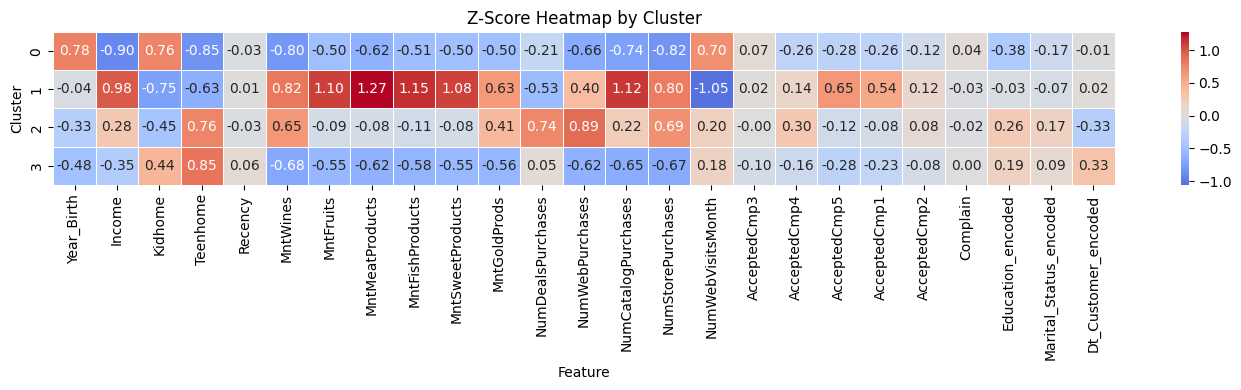

In [63]:
plt.figure(figsize=(14, 4))
sns.heatmap(cluster_z_means, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title("Z-Score Heatmap by Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

It's also sometimes helpful to provide additional context by reviewing the averages for each cluster, without any normalization:

In [66]:
data['Cluster'] = kmeans_clusters
cluster_means = data.groupby('Cluster').mean(numeric_only=True)
cluster_means

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Education_encoded,Marital_Status_encoded,Dt_Customer_encoded
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,1978.129472,29542.599773,0.853492,0.042589,48.190801,33.494037,6.282794,26.724020,9.494037,6.473595,17.950596,1.923339,2.247019,0.511073,3.109029,7.006814,0.090290,0.005111,0.000000,0.001704,0.000000,0.013629,2.076661,1.303237,2013.022147
1,1968.321859,76680.387399,0.039587,0.165232,49.468158,580.886403,69.972461,453.884682,100.595525,71.783133,76.944923,1.308090,5.196213,5.944923,8.378657,2.765921,0.079174,0.110155,0.240964,0.197935,0.027539,0.006885,2.432014,1.406196,2013.043029
2,1964.891544,59145.257241,0.202206,0.920956,48.143382,523.448529,22.678309,148.599265,31.384191,23.610294,65.446691,3.748162,6.553309,3.318015,8.018382,5.792279,0.071691,0.152574,0.042279,0.044118,0.022059,0.007353,2.722426,1.656250,2012.799632
3,1963.005682,43354.091646,0.683712,0.969697,50.731061,73.681818,4.238636,26.015152,5.615530,4.301136,14.704545,2.424242,2.361742,0.765152,3.626894,5.753788,0.047348,0.032197,0.000000,0.007576,0.003788,0.009470,2.647727,1.570076,2013.253788


So what are the key aspects defining each cluster? Let's review the top 3 most extreme z-scores in each cluster to find out:

In [64]:
cluster_z_means.apply(lambda x: x.abs().sort_values(ascending=False).head(3), axis=1)

,Income,MntFishProducts,MntMeatProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,Teenhome
Cluster,,,,,,,,,
0,0.903571,NaN,NaN,NaN,NaN,NaN,0.824910,NaN,0.851665
1,NaN,1.154775,1.271507,NaN,1.123328,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.7367,NaN,0.888554,0.761744
3,NaN,NaN,NaN,0.684216,NaN,NaN,0.665578,NaN,0.851273


Here's what the table tells us about each cluster:

* **Cluster 0: The frugal young parent**. They tend to have the lowest income (average \$29,542), the fewest number of in-store purchases, and is least likely to have teenagers in the home (average 0.04), but most likely to have children in the home (average 0.85).
* **Cluster 1: The rich, high-spender**. They tend to spend the most money, especially on fish and meat products, have the highest income of any cluster (average \$76,680), and they make the most catalog purchases of any group.
* **Cluster 2: The deal-hunting teen parent**. They tend to have the most purchases that involve a deal or coupon, and have the most purchases through the website than any other group. Also, they are also one of the most likely cluster to have more teenagers in the home.
* **Cluster 3: The frugal teen parent** They tend to spend very litte on wine, and most other products, tend to have few purchases across all methods (in-store, online, catalog), but is also most likely to have teenagers in the home.

So how does this stack up against the 5 marketing campaigns? Did certain clusters engage more with certain marketing campaign. Let's see:

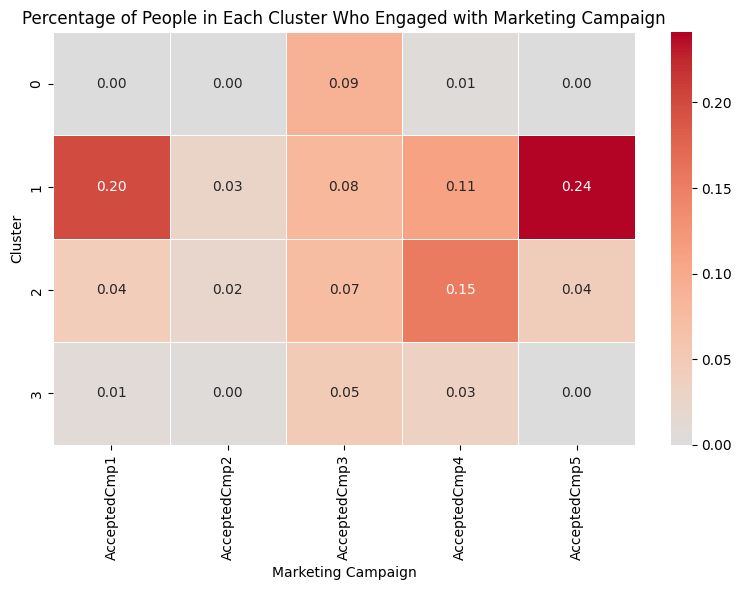

In [75]:
cluster_engagement = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Cluster']].groupby('Cluster').mean()

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_engagement, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title("Percentage of People in Each Cluster Who Engaged with Marketing Campaign")
plt.xlabel("Marketing Campaign")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

As a marketing agency, this information can be really useful! We've identified that **cluster 1 is really the big spenders, so it's no suprise that cluster 1 had some of the strongest engagements** with marketing campaigns, especially campaigns 1 and 5.

It is also interesting that **campaign 4 had the most engagement with cluster 2**, so there must have been something about cluster 2 that clicked with campaign 4. It's hard to tell without more information, but maybe it had really good deals that attracted the deal-hunting parents in that cluster.

It also makes sense that **cluster 0 doesn't offer much engagement** to any campaign, since they tend to spend little and have the lowest income. Marketers targeting cluster 0 would want to look closely at campaign 3 to see how they could improve engagement with this group.

#### Discussion and conclusions

Learning and key takeaways:

*   The approach to **unsupervised learning is fundamentally different from supervised learning** because there is no ground truth labels to evaluate performance on. I didn't realize I would be leaning more on rules of thumb and visualizations to assess how each model did with clustering the dataset.
*   I had become very comfortable with spliting the dataset into training and testing, and using accuracy-related metrics on the test set to assess model performance. **Finding ways to compare unsupervised learning algorithm output** definitely was a good step outside my comfort zone.
*   Once again, data cleaning was such a key step before model training. **Bad data in, bad data out**. Without thoroughly vetting the data that a model will be trained on, the model results cannot be trusted.

What didn't work and why:

*   I had some **difficulties working with the dendrogram** to decide how many clusters I wanted to have in heirarchical clustering. The common rule of thumb suggested that 2 clusters was the best, but I wanted more than 2, and those additional clusters may have negatively impacted the model's performance.
*   When first trying to compare the feature means between the different clusters, I had not standardized the data, which created some pretty unfair comparisons. **Standardizing is key when making comparisons across columns**.

Suggestions for improvement:

*   I'd really like to **dig deeper into DBSCAN clustering and why it didn't work** well for this dataset. My current thinking is that the dimensionality of the dataset may have been too high, and DBSCAN relies on density-based clustering, and density becomes more diluted when more dimensions are added.
*   Earlier in the project, I used a multiple regression model to fill in missing value in the income column. I have no idea if those values were accurate. It would be great to **explore some way to evaluate whether that method of handling missing values can be trusted**.
*   I think it would be really interesting to have more information about the five different marketing campaigns, so we could make some more conclusions about what is happening beyond the data. That **additional context** would be beneficial for a marketing team or advertising firm.